In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from finitedmrgrhomagn import finite_system_algorithm,Block,model_d
import qutip as q
from scipy import integrate,special
from scipy.linalg import eig,eigh,eigvals,eigvalsh
from scipy.sparse.linalg import eigs
import pickle 
from functions import doApplyHam,isingmodel,diagonalize
from functions import isingmodel_rev,isingmodel_rev_frac2
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK

# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple

In [2]:
def gzero(phi,lamb):
    return (1/(2*np.pi))*(lamb-np.cos(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
def guno(phi,lamb):
    return (1/(2*np.pi))*(lamb*np.cos(phi)-np.cos(2*phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))  
def gmenouno(phi,lamb):
    return (1/(2*np.pi))*(lamb*np.cos(phi)-1)/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
def gzero(phi,lamb):
    return (1/(2*np.pi))*(lamb-np.cos(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
def guno(phi,lamb):
    return (1/(2*np.pi))*(lamb*np.cos(phi)-np.cos(2*phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))  
def gmenouno(phi,lamb):
    return (1/(2*np.pi))*(lamb*np.cos(phi)-1)/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
def sigma(n):
    if n==0:
        return q.identity(2)
    if n==1:
        return q.sigmax()
    if n==2:
        return q.sigmay()
    if n==3:
        return q.sigmaz()
    
def gzerok(N,lamb):
    g=0.0
    for k in np.arange(N/2+1):
        g+=(lamb-np.cos(2*np.pi*k/N))/np.sqrt(1+lamb**2-2*lamb*np.cos(2*np.pi*k/N))
    return 2*g/N
def gunok(N,lamb):
    g=0.0
    for k in np.arange(N/2+1):
        g+=(lamb*np.cos(2*np.pi*k/N)-np.cos(2*2*np.pi*k/N))/np.sqrt(1+lamb**2-2*lamb*np.cos(2*np.pi*k/N))
    return 2*g/N
def gmenounok(N,lamb):
    g=0.0
    for k in np.arange(N/2+1):
        g+=(lamb*np.cos(2*np.pi*k/N)-1)/np.sqrt(1+lamb**2-2*lamb*np.cos(2*np.pi*k/N))
    return 2*g/N                                         

def rho_2(x):
    return (1/4)*(q.tensor(sigma(0),sigma(0))-im1vec[x]*q.tensor(sigma(1),sigma(1))-i1vec[x]*q.tensor(sigma(2),sigma(2))+ \
                  (i0vec[x]**2-i1vec[x]*im1vec[x])*q.tensor(sigma(3),sigma(3))+i0vec[x]*(q.tensor(sigma(0),sigma(3))+q.tensor(sigma(3),sigma(0))))


In [3]:
sX = np.array([[0, 1], [1, 0]], dtype='d') 
rho_dict={}
lambdarange=np.linspace(0.1,2,30)
def H2(Sx1, Sx2):  # two-site part of H
    
    return -0.5*(kron(Sx1, Sx2.conjugate().transpose()))
for lam in lambdarange:
    
    H1 = -0.5*lam*np.array([[1, 0], [0, -1]], dtype='d')
    
    #-h*np.array([[0, 1], [1, 0]], dtype='d') # single-site portion of H 

    site = Block(length=1, basis_size=model_d, operator_dict={
        "H": H1,
        "conn_Sx": sX,
        })

    rho_dict[lam]=finite_system_algorithm(site,site,H2,L=50, m_warmup=3, m_sweep_list=[10,20,30])

    print(lam)




=========================**------------------------
0.1
=========================**------------------------
0.16551724137931034
=========================**------------------------
0.23103448275862068
=========================**------------------------
0.296551724137931
=========================**------------------------
0.3620689655172413
=========================**------------------------
0.4275862068965517
=========================**------------------------
0.49310344827586206
=========================**------------------------
0.5586206896551723
=========================**------------------------
0.6241379310344827
=========================**------------------------
0.689655172413793
=========================**------------------------
0.7551724137931034
=========================**------------------------
0.8206896551724137
=========================**------------------------
0.886206896551724
=========================**------------------------
0.9517241379310344
=====================

In [4]:
rho_spectra={}
for el in lambdarange:
    rho_spectra[el]=np.sort(eigvalsh(rho_dict[el]))

In [5]:
lambdarange=np.linspace(0.1,2,30)

i0vec=np.zeros_like(lambdarange)
i1vec=np.zeros_like(lambdarange)
im1vec=np.zeros_like(lambdarange)
i=0
for lam in lambdarange:
    I_0=integrate.quad(gzero,0,2*np.pi,args=(lam))
    I_1=integrate.quad(guno,0,2*np.pi,args=(lam))
    I_m1=integrate.quad(gmenouno,0,2*np.pi,args=(lam))
    i0vec[i]=I_0[0]
    i1vec[i]=I_1[0]
    im1vec[i]=I_m1[0]
    i+=1
    

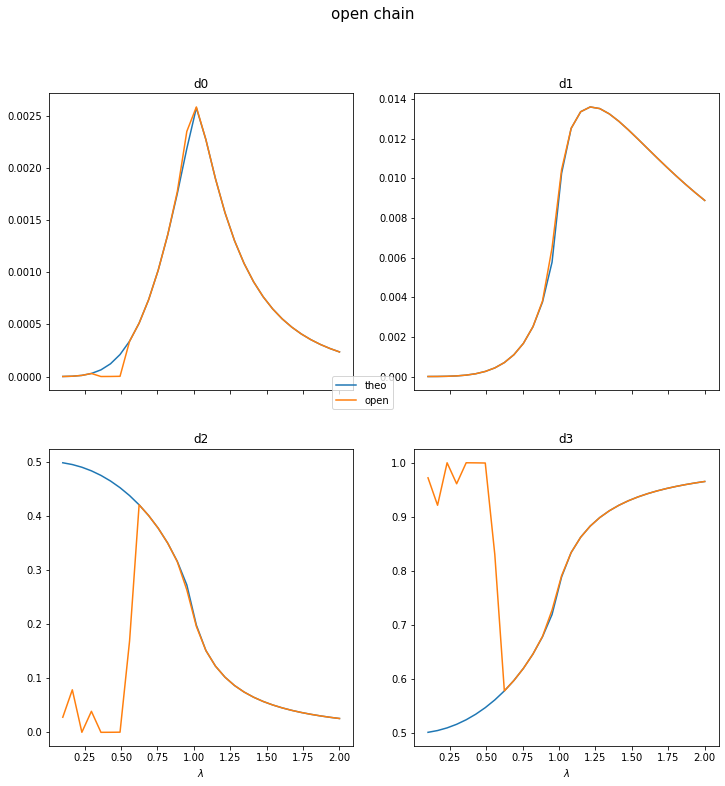

In [6]:
fig, axs = plt.subplots(2, 2,sharex=True,figsize=[12,12])

for k in range(4):
    kb=format(k,"02b")
    kbvec=[int(x) for x in str(kb)]
    specvec= np.zeros_like(lambdarange)
    i=0
    for el in lambdarange:
        specvec[i]=rho_spectra[el][k]
        i+=1
    
    theovec=np.zeros_like(lambdarange)
    for el in np.arange(len(lambdarange)):
        theovec[el]=rho_2(el).eigenenergies()[k]

    axs[kbvec[0], kbvec[1]].plot(lambdarange,theovec,label="theo")
    axs[kbvec[0], kbvec[1]].plot(lambdarange,specvec,label="open")
    axs[kbvec[0], kbvec[1]].set_title('d'+str(k))
handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
fig.suptitle(r"open chain",fontsize=15)
axs[1,1].set_xlabel(r"$\lambda$")
axs[1,0].set_xlabel(r"$\lambda$")
plt.show()    